In [81]:
import os
import ray
import torch
from ray.rllib.algorithms import ppo

In [82]:
import os
import sys
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)
from environments.al_harvest_env import al_harvest_env_creator

In [83]:
from config import get_experiment_config
num_workers = 8
use_tf_board = True
random_seed = 136838
# the below settings should only be changed if you add support for a new substrate
experiment_name = f'al_harvest'
substrate_name = 'allelopathic_harvest__open'
env_creator = al_harvest_env_creator
default_config = ppo.PPOConfig()
default_config.use_custom_reward = False

configs, exp_config, tune_config = get_experiment_config(default_config, 
                                                         '.', 
                                                         num_workers, 
                                                         experiment_name,
                                                         substrate_name,
                                                         env_creator)
env = al_harvest_env_creator(configs.env_config)

(240, 232, 3)


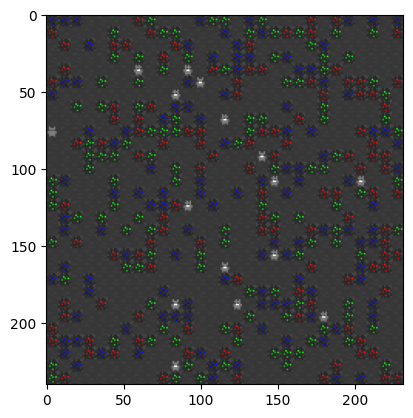

In [84]:
import matplotlib.pyplot as plt

env.reset()
obs = env.render()
print(obs.shape)
plt.imshow(obs)

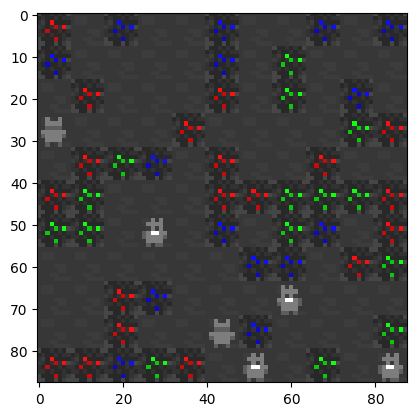

In [85]:
plt.imshow(env._env.observation()[2]['RGB'])

In [86]:
from environments.al_harvest_env import downsample_observation, find_nearest_berry, RIPE_BERRY_COLORS, UNRIPE_NONRED_COLORS

(11, 11, 3)


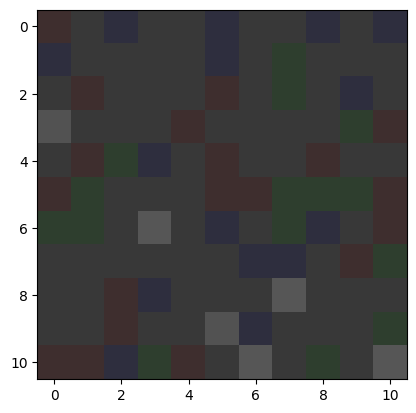

In [87]:
down_obs2 = downsample_observation(env._env.observation()[2]['RGB'], 8)
print(down_obs2.shape)
plt.imshow(down_obs2)

In [88]:
down_obs2[0,2]

array([46, 46, 62], dtype=uint8)

In [89]:
import numpy as np

(264, 264, 3)


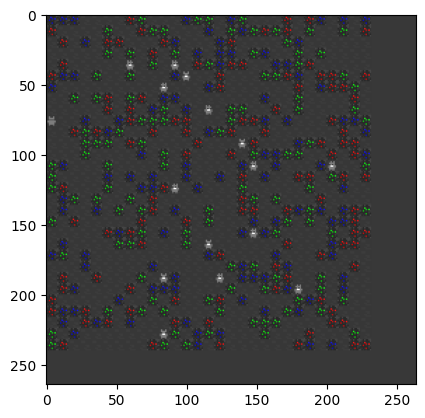

In [90]:
padded_obs = np.pad(obs, [[0, 24], [0, 32], [0, 0]], 'constant', constant_values=56)
print(padded_obs.shape)
plt.imshow(padded_obs)

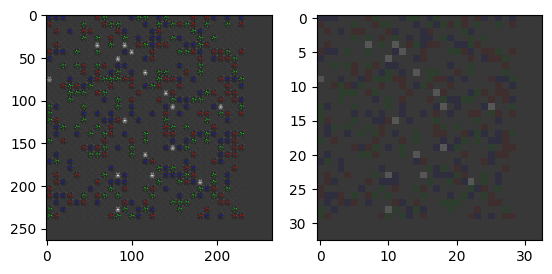

In [91]:
# have to down sample each 88x88 patch then stitch together
orig_obs = padded_obs
down_world_obs = np.zeros([padded_obs.shape[0]//8, padded_obs.shape[1]//8, 3], dtype=int)

# pad the global obs image to 264x264 with grey color
for i in range(0, 240, 88):
    for j in range(0, 232, 88):
        # print((i,j), (i+88, j+88))
        down_world_obs[i//8:i//8+11, j//8:j//8+11, :] = downsample_observation(orig_obs[i:i+88, j:j+88, :], 8)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(orig_obs)
axarr[1].imshow(down_world_obs)

# This is wrong
# down_world_obs = downsample_observation(env._env.observation()[2]['WORLD.RGB'], 8)
# print(down_world_obs.shape)
# plt.imshow(down_world_obs)
# plt.axis('off')

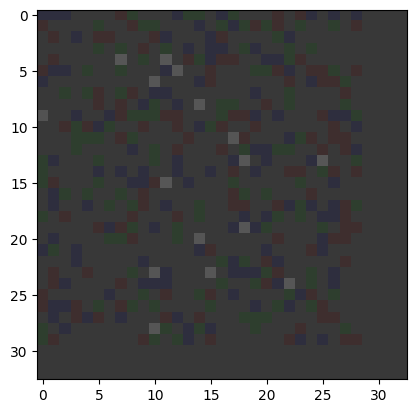

In [92]:
plt.imshow(down_world_obs)
# plt.axis('off')

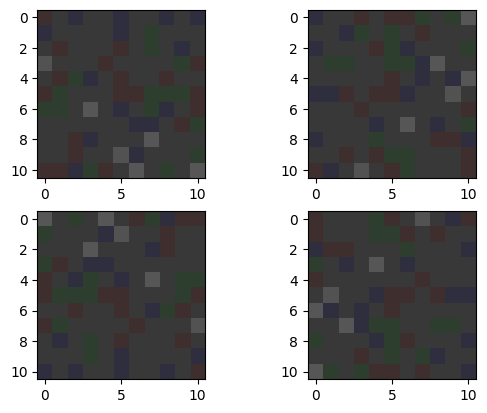

In [93]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(np.rot90(down_obs2, 0, axes=[0,1]))
axarr[0,1].imshow(np.rot90(down_obs2, 1, axes=[0,1]))
axarr[1,0].imshow(np.rot90(down_obs2, 2, axes=[0,1]))
axarr[1,1].imshow(np.rot90(down_obs2, 3, axes=[0,1]))

In [94]:
# Find each agent's glocal coordination
row, col = down_world_obs.shape[:2]
score = 9999
pos = (-1, -1, -1)
for i in range(row-10):
    for j in range(col-10):
        # even though the agent color might not be matching, we can still use the most 
        # matching patch as the true location!
        if len(np.where(down_world_obs[i:i+11, j:j+11, :] - np.rot90(down_obs2, 0, axes=[0,1]))[0])//3 < score:
            score = len(np.where(down_world_obs[i:i+11, j:j+11, :] - np.rot90(down_obs2, 0, axes=[0,1]))[0])//3
            pos = (i, j, 0)
        elif len(np.where(down_world_obs[i:i+11, j:j+11, :] - np.rot90(down_obs2, 1, axes=[0,1]))[0])//3 < score:
            score = len(np.where(down_world_obs[i:i+11, j:j+11, :] - np.rot90(down_obs2, 1, axes=[0,1]))[0])//3
            pos = (i, j, 1)
        elif len(np.where(down_world_obs[i:i+11, j:j+11, :] - np.rot90(down_obs2, 2, axes=[0,1]))[0])//3 < score:
            score = len(np.where(down_world_obs[i:i+11, j:j+11, :] - np.rot90(down_obs2, 2, axes=[0,1]))[0])//3
            pos = (i, j, 2)
        elif len(np.where(down_world_obs[i:i+11, j:j+11, :] - np.rot90(down_obs2, 3, axes=[0,1]))[0])//3 < score:
            score = len(np.where(down_world_obs[i:i+11, j:j+11, :] - np.rot90(down_obs2, 3, axes=[0,1]))[0])//3
            pos = (i, j, 3)

# at this pos[:2] position, the agent view rotated by pos[2]x90 will match the global view 
print(score, pos)



2 (4, 7, 2)


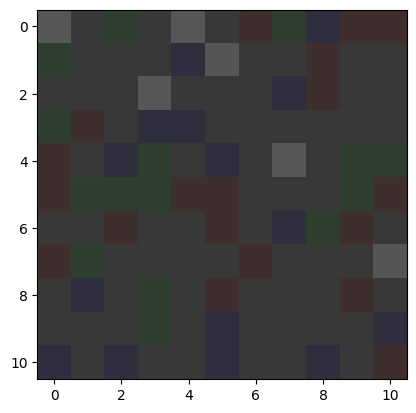

In [95]:
plt.imshow(down_world_obs[pos[0]:pos[0]+11, pos[1]:pos[1]+11, :])

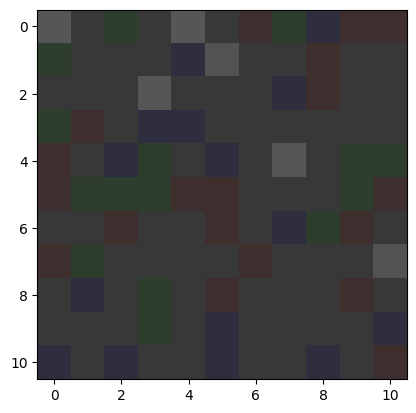

In [96]:
plt.imshow(np.rot90(down_obs2, pos[2], axes=[0,1]))

In [97]:
import copy

In [98]:
# Map the rotation angle to agent's coordinate relative to pos[:2]
# in all circumstances, the agent is always looking toward the center of the square
agent_pos_mapping = {
    0:(9,5),
    1:(5,9),
    2:(1,5),
    3:(5,1),
}

agent_front_pos_mapping = {
    0:(8,5),
    1:(5,8),
    2:(2,5),
    3:(5,2),
}

# this is the agent's global coordinate
agent_loc_global = np.array(pos[:2]) + np.array(agent_pos_mapping[pos[2]])
agent_front_loc_global = np.array(pos[:2]) + np.array(agent_front_pos_mapping[pos[2]])
print(pos, agent_loc_global)

rgb_data = copy.deepcopy(down_world_obs)
target_colors = copy.deepcopy(UNRIPE_NONRED_COLORS)
agent_pos = copy.deepcopy(agent_loc_global)
agent_front_pos = copy.deepcopy(agent_front_loc_global)
offset_in_front_of_player = True
# Below will go into "find_nearest_berry_global"
nearest_pixel, shortest_distance = None, None
combined_mask = np.zeros((33, 33), dtype=bool)

# Create a mask for each target color and combine them
for color in target_colors:
    mask = np.all(rgb_data == color, axis=-1)
    combined_mask = np.logical_or(combined_mask, mask)

# Get row and column indices of pixels matching any of the target colors
rows, cols = np.where(combined_mask)

# If there's no matching pixel, return None
if len(rows) == 0:
	nearest_pixel, shortest_distance = None, None
      
origin_pos = agent_pos
if offset_in_front_of_player:
    origin_pos = agent_front_pos

# Calculate the Euclidean distance for each matching pixel to the point (10, 6)
distances = np.sqrt((rows - origin_pos[0])**2 + (cols - origin_pos[1])**2)  # Subtracting 1 because of 0-based indexing

# Find the pixel with the minimum distance
min_index = np.argmin(distances)
nearest_pixel = (rows[min_index], cols[min_index])
shortest_distance = distances[min_index]

print(nearest_pixel, shortest_distance)

(4, 7, 2) [ 5 12]
(5, 11) 1.4142135623730951


In [99]:
def rot90point(point, angle=0, img_shape=(33,33)):
    # given a point in a 2D image, rotate the coordinate system 
    # counterclock wise by 90 x (angle % 4), return the coordinate of the point
    # under the new coordinate system

    # assume the input point's coordinate system's origin is at top left
    if angle % 4 == 0:
        new_point = copy.deepcopy(point)
    elif angle % 4 == 1:
        new_point = (point[1], img_shape[0] - point[0])
    elif angle % 4 == 2:
        new_point = (img_shape[0] - point[0], img_shape[1] - point[1])
    else:
        new_point = (img_shape[1] - point[1], point[0])
    return new_point

Agent Global Coord: [ 5 12] | Nearest Unripe Global: (5, 11)
Relateve Unripe: [9 6]| Expected Action: 4


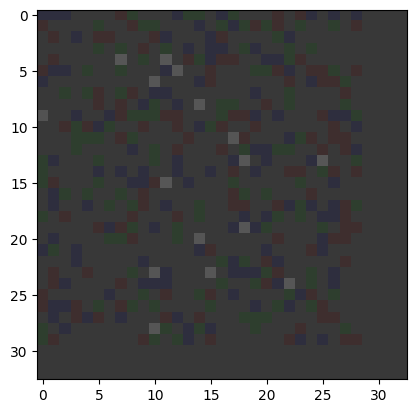

In [100]:
from environments.al_harvest_env import direction_from_reference, direction_to_number
# calculate reward
# For unripe
action = 0

# Translate the global coordinate of the nearest unripe returned 
# to local coordinate relative to the agent ego centric view
# 1. rotate the coordinate system to be the same as the agent-cetric one
# 2. remap the coordinates by agent's local view 
#    (consistent with the (9,5) agent position)
nearest_unripe = nearest_pixel
relative_nearest_unripe = rot90point(nearest_unripe, angle=pos[2]) + np.array([9, 5]) - rot90point(agent_loc_global, angle=pos[2])
# Compute expected movement direction
direction = direction_from_reference(relative_nearest_unripe)
expected_action = direction_to_number(direction)
print(f'Agent Global Coord: {agent_loc_global} | Nearest Unripe Global: {nearest_unripe}')
print(f'Relateve Unripe: {relative_nearest_unripe}| Expected Action: {expected_action}')
plt.imshow(down_world_obs)
#   'up': 1,
#   'down': 2,
#   'left': 3,
#   'right': 4,

